In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
from sklearn.base import clone
import numpy as np
import sklearn.metrics as metrics
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn import tree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from collections import  Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from IPython.display import display

In [ ]:
df = pd.read_csv("FinalDataset.csv")

In [ ]:
df.head()

,Unnamed: 0,id,date,text,STANCE,OPINION,POL,cleanText,cleanTextNoPun,hashtags,mentions,NOUN,PROPN,PRON,ADJ,DET,ADP,VERB,ADV,CONJ,INTJ,AUX,SCONJ,finalCleanText,COUNT_NOUN,COUNT_PROPN,COUNT_PRON,COUNT_ADJ,COUNT_DET,COUNT_ADP,COUNT_VERB,COUNT_ADV,COUNT_CONJ,COUNT_INTJ,COUNT_AUX,COUNT_SCONJ,Positive_Score,Negative_Score,Neutral_Score,Compound Score
0,0,5cb772da884ce419f5ec5257,Tue Apr 16 17:03:11 +0000 2019,"@RealTimeSMU Not just Ferdous, another Banglad...",0,0,0,"Not just Ferdous, another Bangladeshi actor Ga...",Not just Ferdous another Bangladeshi actor Ga...,[[]],['@RealTimeSMU'],"['actor', 'candidate', 'constituency', 'leader...","['Bangladeshi', 'Gazi', 'Abdun', 'Noor', 'TMC'...",['He'],"['Ferdous', 'senior', 'raod']","['another', 'a', 'this', 'the']","['for', 'in', 'by', 'during']","['seen', 'campaigning', 'accompanied', 'come',...",['just'],[],[],"['was', 'was', 'had']",[],ferdous Bangladeshi actor Gazi Abdun Noor see ...,69,99,6,29,31,29,56,8,2,2,21,2,0.000,0.000,1.000,0.0000
1,1,5cb7758f884ce419f5ec55a2,Mon Apr 15 08:25:44 +0000 2019,Villages that cast 80 per cent votes for the B...,1,1,1,Villages that cast per cent votes for the BJP ...,Villages that cast per cent votes for the BJP ...,[[]],['@Manekagandhibjp'],"['Villages', 'cent', 'votes', 'category', 'cen...","['BJP', 'BJP', 'BJP']",[],[],"['that', 'the', 'A', 'those', 'that', 'the']","['per', 'for', 'under', 'per', 'for', 'with', ...","['cast', 'will', 'placed', 'cast', 'will', 'wi...",[],[],[],"['be', 'be', 'be']",['while'],village cast cent vote BJP place category cast...,124,21,2,2,44,68,58,2,2,2,18,9,0.000,0.000,1.000,0.0000
2,2,5cb775c6884ce419f5ec55df,Wed Apr 17 07:13:42 +0000 2019,Deeply saddened that lumpen goons get prefence...,0,1,0,Deeply saddened that lumpen goons get prefence...,Deeply saddened that lumpen goons get prefence...,[[]],['@incindia'],"['goons', 'prefence', 'board', 'party', 'party...",[],"['who', 'who', 'me']","['lumpen', 'unfortunate']","['those', 'their', 'the', 'those', 'the', 'a',...","['in', 'over', 'across', 'for', 'within', 'wit...","['saddened', 'get', 'given', 'Having', 'faced'...","['Deeply', 'yet', 'away', 'even']",[],[],"['have', 'is']",['that'],deeply sadden lumpen goon prefence give sweat&...,67,2,20,25,55,55,72,33,2,2,14,8,0.095,0.182,0.723,-0.7137
3,3,5cb77649884ce419f5ec5681,Mon Apr 15 11:08:07 +0000 2019,Ever wondered where BJP &amp; its allies get t...,2,1,2,Ever wondered where BJP &amp; its allies get t...,Ever wondered where BJP &amp; its allies get t...,['#LokSabhaElections2019'],[[]],"['allies', 'inspiration', 'actions', 'success'...","['BJP', 'amp', 'Dravidian', 'Land', 'power', '...","['them', 'them']","['few', 'precious', 'real']","['its', 'their', 'Their', 'a', 'our', 'a', 'a']","['from', 'in', 'in', 'from', 'on']","['wondered', 'get', 'might', 'seen', 'oust', '...","['Ever', 'where', 'Here', 'wisely']",[],[],"['have', 'is']",[],wonder BJP amp ally inspiration action see suc...,98,51,16,27,47,34,53,35,2,2,14,2,0.260,0.000,0.740,0.9413
4,4,5cb779bb884ce419f5ec5ad5,Wed Apr 17 15:05:29 +0000 2019,To all Delhi pollsters Maharashtra will give y...,2,1,2,To all Delhi pollsters Maharashtra will give y...,To all Delhi pollsters Maharashtra will give y...,['#LokSabhaElections2019'],[[]],"['pollsters', 'shock', 'speech', 'speech', 'ti...","['Delhi', 'Maharashtra', 'May', 'raj', 'saheb'...","['you', 'him']","['big', 'more', 'daily']","['all', 'any', 'every', 'all']","['To', 'on', 'at', 'by']","['will', 'give', 'check', 'addressing', 'booked']","['Just', 'so']",[],[],"['have', 'is']",['than'],Delhi pollster Maharashtra big shock nps check...,89,89,14,24,30,24,49,14,2,2,14,8,0.000,0.057,0.943,-0.3818


In [ ]:
cols = list(df.columns)
index = cols.index("finalCleanText")

In [ ]:
nanIndex = []
nanIndex.extend(list(df[df["STANCE"].isna()].index))
nanIndex.extend(list(df[df["OPINION"].isna()].index))
nanIndex.extend(list(df[df["POL"].isna()].index))
for i in range(index,len(cols)):
    print("checking",cols[i])
    nanIndex.extend(list(df[df[cols[i]].isna()].index))
nanIndex = set(nanIndex)
print("Total nan value found",len(nanIndex))

checking finalCleanText
checking COUNT_NOUN
checking COUNT_PROPN
checking COUNT_PRON
checking COUNT_ADJ
checking COUNT_DET
checking COUNT_ADP
checking COUNT_VERB
checking COUNT_ADV
checking COUNT_CONJ
checking COUNT_INTJ
checking COUNT_AUX
checking COUNT_SCONJ
checking Positive_Score
checking Negative_Score
checking Neutral_Score
checking Compound Score
Total nan value found 2


In [ ]:
df.drop(index=nanIndex,inplace=True)
df.reset_index(inplace=True,drop=True)

In [ ]:
X  = df.iloc[:,index:].copy()
# Y = pd.DataFrame() 
X["cleaned tweets"] = df["finalCleanText"].copy()
del X["finalCleanText"]
# Y["STANCE"] = df["STANCE"].copy()

In [ ]:
X.head()

,COUNT_NOUN,COUNT_PROPN,COUNT_PRON,COUNT_ADJ,COUNT_DET,COUNT_ADP,COUNT_VERB,COUNT_ADV,COUNT_CONJ,COUNT_INTJ,COUNT_AUX,COUNT_SCONJ,Positive_Score,Negative_Score,Neutral_Score,Compound Score,cleaned tweets
0,69,99,6,29,31,29,56,8,2,2,21,2,0.000,0.000,1.000,0.0000,ferdous Bangladeshi actor Gazi Abdun Noor see ...
1,124,21,2,2,44,68,58,2,2,2,18,9,0.000,0.000,1.000,0.0000,village cast cent vote BJP place category cast...
2,67,2,20,25,55,55,72,33,2,2,14,8,0.095,0.182,0.723,-0.7137,deeply sadden lumpen goon prefence give sweat&...
3,98,51,16,27,47,34,53,35,2,2,14,2,0.260,0.000,0.740,0.9413,wonder BJP amp ally inspiration action see suc...
4,89,89,14,24,30,24,49,14,2,2,14,8,0.000,0.057,0.943,-0.3818,Delhi pollster Maharashtra big shock nps check...


In [ ]:
class Results:
    def __init__(self,X,df):
        '''
        Constructor
        takes Raw X and df
        '''
        self.X = X.copy()
        self.df = df.copy()
        self.mapping = {2:"Anti Govt",0:"Neutral",1:"Pro Govt"}
        self.trainingScore = {}
        self.testingScore = {}
    def compareModels(self):
        #Training Accuracies
        df_train = pd.DataFrame(pd.Series(self.trainingScore, name='Accuracy'))
        plot = df_train.plot(kind = 'bar',grid=True,title="Comparison of Training Accuracy")
        plot.set_xlabel("Models")
        plot.set_ylabel("Stance Accuracy")
        fig = plot.get_figure()
        fig.savefig("graphs3.png",bbox_inches='tight')
        df_test = pd.DataFrame(pd.Series(self.testingScore, name='Accuracy'))
        plot = df_test.plot(kind = 'bar',grid=True,title="Comparison of Testing Accuracy")
        plot.set_xlabel("Models")
        plot.set_ylabel("Stance Accuracy")
        fig = plot.get_figure()
        fig.savefig("graphs4.png",bbox_inches='tight')
        
    def createConfusionMatrix(self,y_true_c,y_pred_c,classifier_name):
        y_true = [self.mapping[i] for i in y_true_c]
        y_pred = [self.mapping[i] for i in y_pred_c]
        labels = [self.mapping[key] for key in self.mapping]
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        title = "Confusion Matrix of "+ classifier_name
        fig = plt.figure()
        ax= plt.subplot()
        fig.add_subplot(ax)
        sns.heatmap(cm, annot=True, ax = ax);
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
        ax.set_title(title);
        ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
        fig.savefig("graphs2.png")
        return
        
    def createGraph(self,randomValues,smoteValues,normalValues,classifierName,typeAccuracy,y_value):
        x_len = max(len(randomValues),len(smoteValues),len(normalValues))
        title = "Kcross "+ typeAccuracy +" Scores of "+classifierName
        x = [i for i in range(1,x_len+1)]
        plt.title(title)
        plt.plot(x,randomValues,'o-',label="Random Sampling")
        plt.plot(x, smoteValues,'o-',label="SMOTE Sampling")
        plt.plot(x, normalValues,'o-',label="No Sampling")
        plt.xticks([i for i in range(1,x_len+1)])
        plt.legend()
        plt.grid(True)
        plt.ylabel(y_value+" Accuracy")
        plt.xlabel("Folds")
        plt.legend()
        plt.savefig("graphs1.png")
        plt.show()
    def getValue(self,y_value):
        '''
            y_value can be 'STANCE' OR 'OPINION' OR 'POL'
            Internal Method, not to be used by user
            returns X,Y
        '''
        X = self.X.copy()
        df = self.df.copy()
        Y = pd.DataFrame()
        Y[y_value] = df[y_value]
        return X,Y
    def process(self,X_train,y_train,X_test,y_test):
        '''
            y_value can be 'STANCE' OR 'OPINION' OR 'POL'
            return in the order x_train,y_train,x_test,y_test
            Xs should be dataframes and Ys should be np array
        '''
        tfidf = TfidfVectorizer(use_idf=True,min_df=0.01,max_df=0.9)
        x_train = tfidf.fit_transform(list(X_train['cleaned tweets'].values))
        x_test = tfidf.transform(list(X_test['cleaned tweets'].values))
        x_train = x_train.toarray()
        x_test = x_test.toarray()
        x_train = pd.DataFrame(data=x_train,columns=list(tfidf.get_feature_names()))
        x_test = pd.DataFrame(data=x_test,columns=list(tfidf.get_feature_names()))
        del X_train['cleaned tweets']
        del X_test['cleaned tweets']
        x_train = pd.concat([X_train,x_train],axis=1)
        x_test = pd.concat([X_test,x_test],axis=1)
#         print("This is to check all x_train columns are unique")
        assert(len(list(x_train.columns)) == len(set(list(x_train.columns))))
        assert(list(x_train.columns) == list(x_test.columns))
        column = list(x_train.columns)
        index = column.index('Positive_Score')
#         print("min max scaler on",column[:index])
        for feature in column[:index]:
            scaler = preprocessing.MinMaxScaler()
            scaler.fit(x_train[feature].values.reshape((-1,1)))
            x_train[feature] = scaler.transform(x_train[feature].values.reshape((-1,1)))
            x_test[feature] = scaler.transform(x_test[feature].values.reshape((-1,1)))
        x_train = x_train.values
        x_test = x_test.values
        y_train = y_train.reshape(-1)
        y_test = y_test.reshape(-1)
        return x_train,y_train,x_test,y_test
    def evaluate(self,classifier,y_value,classifier_name=None,method = None):
        '''
            y_value can be 'STANCE' OR 'OPINION' OR 'POL'
            prints accuracy and Confusion Matrix
            classifier is sklearn classifier object
            y_value is either STANCE,OP,Polarization
            method is the oversampling objects, supports SMOTE etc..
        '''
        X,Y = self.getValue(y_value)
        X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.25, random_state = 20)
        X_train.reset_index(inplace=True,drop=True)
        X_test.reset_index(inplace=True,drop=True)
        y_train = y_train.values
        y_test = y_test.values
        x_train,y_train,x_test,y_test = self.process(X_train,y_train,X_test,y_test)
        if method is not None:
            x_train, y_train = method().fit_resample(x_train, y_train)
        training_score,testing_score = self.runModel(x_train,x_test,y_train,y_test,classifier)
        print("Y_value is",y_value)
        print("Training accuracy",training_score)
        print("Testing accuracy",testing_score)
        if classifier_name is not None:
            self.createConfusionMatrix(y_test,classifier.predict(x_test),classifier_name)
            self.testingScore[classifier_name] = testing_score
            self.trainingScore[classifier_name] = training_score
#         print("Confusion Matrix")
#         display(confusion_matrix(y_test,classifier.predict(x_test)))
#         print(y_test)
#         print(classifier.predict(x_test))
        return
    def runModel(self,x_train,x_test,y_train,y_test,classifier):
        '''
            returns training_score,testing_score
            Takes processed x and y 
        '''
        classifier.fit(x_train,y_train)
        training_score = classifier.score(x_train,y_train)
        testing_score = classifier.score(x_test,y_test)
        return training_score,testing_score
    def kcross(self,classifier,y_value,classifierName = None):
        '''
            y_value can be 'STANCE' OR 'OPINION' OR 'POL'
            prints complete kcross validation scores including oversampling techinques
        '''
        training_scores,testing_scores = [],[]
        training_scores_random,testing_scores_random = [],[]
        training_scores_smote,testing_scores_smote = [],[]
        X,Y = self.getValue(y_value)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
        for train_index, test_index in skf.split(X, Y):
            X_train, X_test = X[X.index.isin(train_index)].copy(), X[X.index.isin(test_index)].copy()
            y_train, y_test = Y[Y.index.isin(train_index)].copy(), Y[Y.index.isin(test_index)].copy()
            X_train.reset_index(inplace=True, drop=True)
            X_test.reset_index(inplace=True, drop=True)
            y_train = y_train.values
            y_test = y_test.values
            x_train,y_train,x_test,y_test = self.process(X_train,y_train,X_test,y_test)
            #### Smote over Sampling #####
            x_train_smote, y_train_smote = SMOTE().fit_resample(x_train, y_train)
            train_smote_score,test_smote_score = self.runModel(x_train_smote,x_test,y_train_smote,y_test,clone(classifier))
            training_scores_smote.append(train_smote_score)
            testing_scores_smote.append(test_smote_score)
            ### Random Over Sampling #####
            x_train_random, y_train_random = RandomOverSampler().fit_resample(x_train, y_train)
            train_random_score,test_random_score = self.runModel(x_train_random,x_test,y_train_random,y_test,clone(classifier))
            training_scores_random.append(train_random_score)
            testing_scores_random.append(test_random_score)
            ##### Normal Stuff ###########
            train_score,test_score = self.runModel(x_train,x_test,y_train,y_test,clone(classifier))
            training_scores.append(train_score)
            testing_scores.append(test_score)
        print("Random sampling scores")
        try:
            print("AVERAGE TRAINING SCORE",sum(training_scores_random)/len(training_scores_random))
        except:
            print("some error")
        try:
            print("AVERAGE TESTING SCORE",sum(testing_scores_random)/len(testing_scores_random))
        except:
            print("some error")
        print("smote sampling scores")
        try:
            print("AVERAGE TRAINING SCORE",sum(training_scores_smote)/len(training_scores_smote))
        except:
            print("some error")
        try:
            print("AVERAGE TESTING SCORE",sum(testing_scores_smote)/len(testing_scores_smote))
        except:
            print("some error")
        
        print("Normal scores")
        try:
            print("AVERAGE TRAINING SCORE",sum(training_scores)/len(training_scores))
        except:
            print("some error")
        try:
            print("AVERAGE TESTING SCORE",sum(testing_scores)/len(testing_scores))
        except:
            print("some error")
        if classifierName is not None:
            self.createGraph(training_scores_random,training_scores_smote,training_scores,classifierName,"Training",y_value.lower().capitalize())
            self.createGraph(testing_scores_random,testing_scores_smote,testing_scores,classifierName,"Validation",y_value.lower().capitalize())


In [ ]:
result = Results(X,df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

Random sampling scores
AVERAGE TRAINING SCORE 0.8635566188197767
AVERAGE TESTING SCORE 0.6268472077288181
smote sampling scores
AVERAGE TRAINING SCORE 0.8598883572567783
AVERAGE TESTING SCORE 0.6264373716632443
Normal scores
AVERAGE TRAINING SCORE 0.8102417076940419
AVERAGE TESTING SCORE 0.6264398963207325


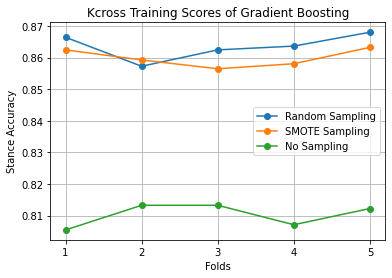

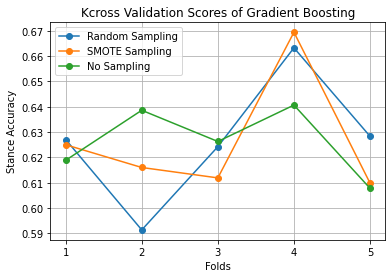

In [ ]:
result.kcross(GradientBoostingClassifier(learning_rate=0.1),'STANCE',"Gradient Boosting")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

Random sampling scores
AVERAGE TRAINING SCORE 0.5623604465709728
AVERAGE TESTING SCORE 0.3661712727639951
smote sampling scores
AVERAGE TRAINING SCORE 0.5885167464114833
AVERAGE TESTING SCORE 0.38505234456525395
Normal scores
AVERAGE TRAINING SCORE 0.4611059428148801
AVERAGE TESTING SCORE 0.3518051301040159


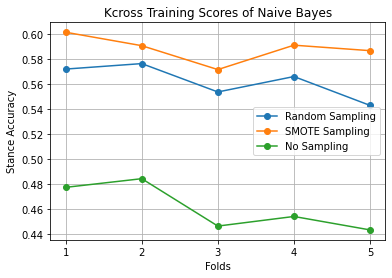

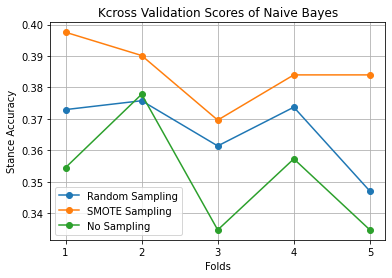

In [ ]:
result.kcross(GaussianNB(),'STANCE',"Naive Bayes")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

Random sampling scores
AVERAGE TRAINING SCORE 0.8774322169059012
AVERAGE TESTING SCORE 0.6223247046150739
smote sampling scores
AVERAGE TRAINING SCORE 0.8833333333333334
AVERAGE TESTING SCORE 0.6243823004679031
Normal scores
AVERAGE TRAINING SCORE 0.7824301516177937
AVERAGE TESTING SCORE 0.5931800585720538


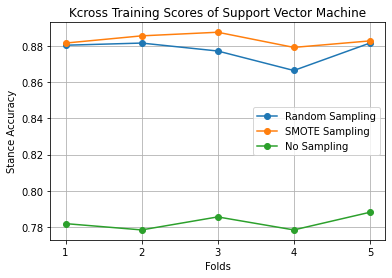

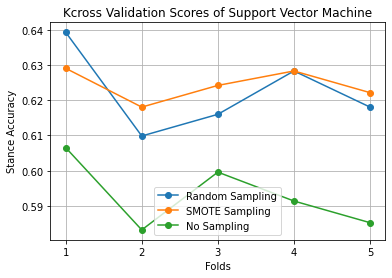

In [ ]:
result.kcross(SVC(C=1),'STANCE',"Support Vector Machine")

In [ ]:
# result.kcross(RandomForestClassifier(n_estimators=200,min_samples_leaf=5,min_samples_split=3,random_state=21),'STANCE',"Random Forest ")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

Random sampling scores
AVERAGE TRAINING SCORE 0.9756778309409888
AVERAGE TESTING SCORE 0.7081192984818394
smote sampling scores
AVERAGE TRAINING SCORE 0.9772727272727273
AVERAGE TESTING SCORE 0.7023773858013262
Normal scores
AVERAGE TRAINING SCORE 0.9707510722605075
AVERAGE TESTING SCORE 0.7073063587706601


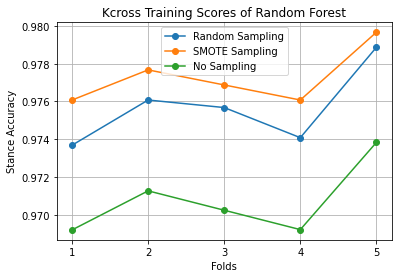

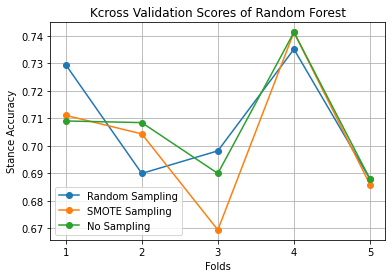

In [ ]:
result.kcross(RandomForestClassifier(n_estimators=90,random_state=30,oob_score=True,max_features='auto'),'STANCE',"Random Forest")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Y_value is STANCE
Training accuracy 0.8308702791461412
Training accuracy 0.6075533661740559


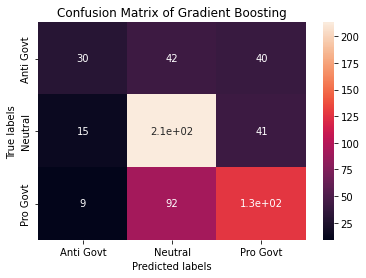

In [ ]:
result.evaluate(GradientBoostingClassifier(learning_rate=0.1),'STANCE',"Gradient Boosting")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Y_value is STANCE
Training accuracy 0.4783798576902025
Training accuracy 0.3579638752052545


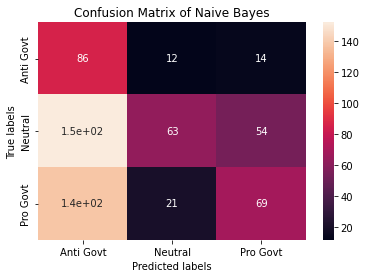

In [ ]:
result.evaluate(GaussianNB(),'STANCE',"Naive Bayes")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Y_value is STANCE
Training accuracy 0.7952928297755884
Training accuracy 0.5960591133004927


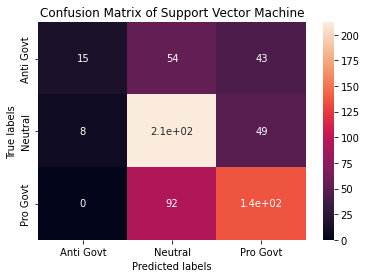

In [ ]:
result.evaluate(SVC(C=1),'STANCE',"Support Vector Machine")

In [ ]:
# result.evaluate(RandomForestClassifier(n_estimators=200,min_samples_leaf=5,min_samples_split=3,random_state=21),'STANCE',"Random Forest ")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Y_value is STANCE
Training accuracy 0.9753694581280788
Training accuracy 0.6798029556650246


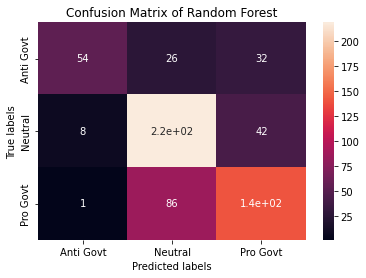

In [ ]:
result.evaluate(RandomForestClassifier(n_estimators=90,random_state=30,oob_score=True,max_features='auto'),'STANCE',"Random Forest")

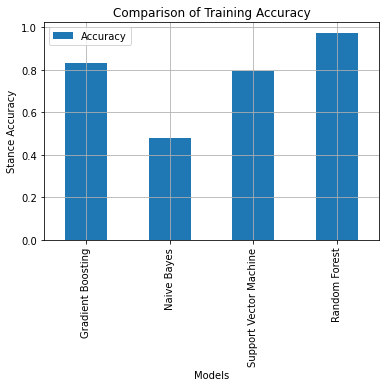

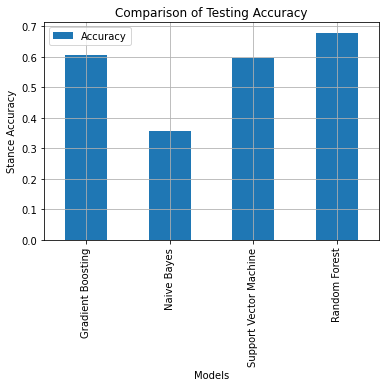

In [ ]:
result.compareModels()